# Segmenting and Clustering Neighborhoods in Kyoto, Japan

In [1]:
! pip install lxml html5lib beautifulsoup4

     |████████████████████████████████| 5.8MB 8.4MB/s eta 0:00:01
     |████████████████████████████████| 112kB 33.7MB/s eta 0:00:01


In [2]:
# geopy
!conda install -c conda-forge geopy --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    sci

In [3]:
# Foursquare API
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [4]:
import pandas as pd
import numpy as np

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Foursquare API
import folium # map rendering library

## 1. Download data and clean it up

### Download Japan postal code data from JAPAN POST Co.,Ltd.

In [5]:
# Download Japan postal code data if not yet downloaded
!wget -q -O 'japan_postal_codes.zip' https://www.post.japanpost.jp/zipcode/dl/roman/ken_all_rome.zip?190712
print('Data downloaded!')

In [6]:
!unzip -o 'japan_postal_codes.zip'

Archive:  japan_postal_codes.zip
  inflating: KEN_ALL_ROME.CSV        


In [7]:
# read csv.
# 1. assign header to the columns. the addresses are written in both Japanese and English.
# 2. latitude and longitude are not available in this csv. they will be filled later using geopy.
df = pd.read_csv('KEN_ALL_ROME.CSV', names =['PostalCode', 'Prefecture-JP', 'Borough-JP', 'Neighborhood-JP', 'Prefecture', 'Borough', 'Neighborhood', 'Latitude', 'Longitude'], encoding="SHIFT-JIS")
df.head()

,PostalCode,Prefecture-JP,Borough-JP,Neighborhood-JP,Prefecture,Borough,Neighborhood,Latitude,Longitude
0,600000,北海道,札幌市 中央区,以下に掲載がない場合,HOKKAIDO,SAPPORO SHI CHUO KU,IKANIKEISAIGANAIBAAI,NaN,NaN
1,640941,北海道,札幌市 中央区,旭ケ丘,HOKKAIDO,SAPPORO SHI CHUO KU,ASAHIGAOKA,NaN,NaN
2,600041,北海道,札幌市 中央区,大通東,HOKKAIDO,SAPPORO SHI CHUO KU,ODORIHIGASHI,NaN,NaN
3,600042,北海道,札幌市 中央区,大通西（１〜１９丁目）,HOKKAIDO,SAPPORO SHI CHUO KU,ODORINISHI(1-19-CHOME),NaN,NaN
4,640820,北海道,札幌市 中央区,大通西（２０〜２８丁目）,HOKKAIDO,SAPPORO SHI CHUO KU,ODORINISHI(20-28-CHOME),NaN,NaN


### If neighborhood value is not assigned (='IKANIKEISAIGANAIBAAI'), it is a less populated area. Drop them.

In [8]:
# Check
df[df['Neighborhood'] == 'IKANIKEISAIGANAIBAAI'].shape

(1874, 9)

In [9]:
# Drom them
df = df[df['Neighborhood'] != 'IKANIKEISAIGANAIBAAI']
# Verify
df[df['Neighborhood'] == 'IKANIKEISAIGANAIBAAI'].shape

(0, 9)

### Print the number of rows

In [10]:
df.shape

(122396, 9)

## 2. Explore and cluster the neighborhoods in Kyoto, Japan

### Work with only boroughs in the central area of Kyoto city (='KYOTO SHI KAMIGYO KU' or 'KYOTO SHI NAKAGYO KU')

In [11]:
kyoto_data = df[df['Borough'].str.contains('KYOTO SHI KAMIGYO KU') | df['Borough'].str.contains('KYOTO SHI NAKAGYO KU')].reset_index(drop=True)
kyoto_data.head()

,PostalCode,Prefecture-JP,Borough-JP,Neighborhood-JP,Prefecture,Borough,Neighborhood,Latitude,Longitude
0,6020827,京都府,京都市 上京区,相生町,KYOTO FU,KYOTO SHI KAMIGYO KU,AIOICHO,NaN,NaN
1,6028278,京都府,京都市 上京区,愛染寺町,KYOTO FU,KYOTO SHI KAMIGYO KU,AIZENJICHO,NaN,NaN
2,6020054,京都府,京都市 上京区,飛鳥井町,KYOTO FU,KYOTO SHI KAMIGYO KU,ASUKAICHO,NaN,NaN
3,6020923,京都府,京都市 上京区,油橋詰町,KYOTO FU,KYOTO SHI KAMIGYO KU,ABURAHASHIZUMECHO,NaN,NaN
4,6028165,京都府,京都市 上京区,尼ケ崎横町,KYOTO FU,KYOTO SHI KAMIGYO KU,AMAGASAKIYOKOCHO,NaN,NaN


In [12]:
kyoto_data.shape

(1206, 9)

### Use geopy library to get the latitude and longitude values of the neighborhoods

In [15]:
for index, row in kyoto_data.iterrows():
    address = '{}, {}, {}'.format(row['Neighborhood-JP'], row['Borough-JP'], row['Prefecture-JP'])
    loc = geocode(address)
    if (loc != None):
        kyoto_data.at[index, 'Latitude'] = loc.latitude
        kyoto_data.at[index, 'Longitude'] = loc.longitude
        #print(row)

kyoto_data.head(10)

,PostalCode,Prefecture-JP,Borough-JP,Neighborhood-JP,Prefecture,Borough,Neighborhood,Latitude,Longitude
0,6020827,京都府,京都市 上京区,相生町,KYOTO FU,KYOTO SHI KAMIGYO KU,AIOICHO,35.031141,135.769037
1,6028278,京都府,京都市 上京区,愛染寺町,KYOTO FU,KYOTO SHI KAMIGYO KU,AIZENJICHO,35.023407,135.743734
2,6020054,京都府,京都市 上京区,飛鳥井町,KYOTO FU,KYOTO SHI KAMIGYO KU,ASUKAICHO,NaN,NaN
3,6020923,京都府,京都市 上京区,油橋詰町,KYOTO FU,KYOTO SHI KAMIGYO KU,ABURAHASHIZUMECHO,NaN,NaN
4,6028165,京都府,京都市 上京区,尼ケ崎横町,KYOTO FU,KYOTO SHI KAMIGYO KU,AMAGASAKIYOKOCHO,35.021582,135.742720
5,6028424,京都府,京都市 上京区,阿弥陀寺町,KYOTO FU,KYOTO SHI KAMIGYO KU,AMIDAJICHO,NaN,NaN
6,6020803,京都府,京都市 上京区,阿弥陀寺前町,KYOTO FU,KYOTO SHI KAMIGYO KU,AMIDAJIMAECHO,35.033264,135.766436
7,6028074,京都府,京都市 上京区,有春町,KYOTO FU,KYOTO SHI KAMIGYO KU,ARIHARUCHO,NaN,NaN
8,6028472,京都府,京都市 上京区,有馬町,KYOTO FU,KYOTO SHI KAMIGYO KU,ARIMACHO,35.030387,135.745635
9,6020064,京都府,京都市 上京区,安楽小路町,KYOTO FU,KYOTO SHI KAMIGYO KU,ANRAKUKOJICHO,35.032808,135.755731


In [16]:
# save current data to file
kyoto_data.to_csv('kyoto.csv')
print('Saved CSV')

Saved CSV


In [5]:
kyoto_data = pd.read_csv('kyoto.csv')

In [6]:
# Drop neighborhoods that could not get latitude and longitude from geopy
kyoto_data = kyoto_data.dropna(subset=['Latitude', 'Latitude']).reset_index(drop=True)
kyoto_data.head()

,Unnamed: 0,PostalCode,Prefecture-JP,Borough-JP,Neighborhood-JP,Prefecture,Borough,Neighborhood,Latitude,Longitude
0,0,6020827,京都府,京都市 上京区,相生町,KYOTO FU,KYOTO SHI KAMIGYO KU,AIOICHO,35.031141,135.769037
1,1,6028278,京都府,京都市 上京区,愛染寺町,KYOTO FU,KYOTO SHI KAMIGYO KU,AIZENJICHO,35.023407,135.743734
2,4,6028165,京都府,京都市 上京区,尼ケ崎横町,KYOTO FU,KYOTO SHI KAMIGYO KU,AMAGASAKIYOKOCHO,35.021582,135.742720
3,6,6020803,京都府,京都市 上京区,阿弥陀寺前町,KYOTO FU,KYOTO SHI KAMIGYO KU,AMIDAJIMAECHO,35.033264,135.766436
4,8,6028472,京都府,京都市 上京区,有馬町,KYOTO FU,KYOTO SHI KAMIGYO KU,ARIMACHO,35.030387,135.745635


In [7]:
kyoto_data.shape

(389, 10)

### Create a map of Kyoto with neighborhoods superimposed on top.

In [8]:
address = 'Kyoto, JP' # Kyoto city

geolocator = Nominatim(user_agent="kyoto_city_explorer")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2)
location = geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Kyoto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Kyoto are 35.021041, 135.7556075.


In [9]:
# create map of New York using latitude and longitude values
map_kyoto = folium.Map(location=[latitude, longitude], zoom_start=14)
map_kyoto

In [10]:
# add markers to map
for lat, lng, borough, neighborhood in zip(kyoto_data['Latitude'], kyoto_data['Longitude'], kyoto_data['Borough'], kyoto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kyoto)  
    
map_kyoto

### Explore neighborhoods in Kyoyo

In [11]:
CLIENT_ID = '1RMX12RQK31ECDMFK1LGOOK4FA50VEWF30KYCGFE5WMU0IFL' # your Foursquare ID
CLIENT_SECRET = 'Y2YMCUJBNTHJTKILQMMKZHXO053SB5N4AUTBGUBCSW0LKG3Y' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
kyoto_venues = getNearbyVenues(names=kyoto_data['Neighborhood'], latitudes=kyoto_data['Latitude'], longitudes=kyoto_data['Longitude'])

AIOICHO
AIZENJICHO
AMAGASAKIYOKOCHO
AMIDAJIMAECHO
ARIMACHO
ANRAKUKOJICHO
ISEDONOKAMAECHO
ISEYACHO
IDACHO
ISSHIKICHO
ISSHINCHO
ITOYACHO
INUICHO
IBACHO
IMASHINZAIKECHO
UCHIGAMAECHO
UBAGAENOKICHO
UBAGAKITAMACHI
UBAGATERANOMAECHO
URATSUKIJICHO
URAFUROCHO
EMMAMAECHO
OIMATSUCHO
OKAKUENCHO
OKAMINOCHO
OKITAKOJIHIGASHICHO
OHARAGUCHICHO
OHARAGUCHITSUKINUKECHO
OKAMATSUCHO
KAGAYACHO
KAJIICHO
KASHIWAKIYOMORICHO
KASUGACHO
KATAHARACHO
KAMIOGAWACHO
KAMIKATAHARACHO
KAMIKINOSHITACHO
KAMIGORYONAKAMACHI
KAMIGORYOBABACHO
KAMIGORYOMAECHO
KAMIDACHIURICHO
KAMIDACHIURIHIGASHICHO
KAMITENJINCHO
KAMIYANAGIHARACHO
KAMEKICHO
GANSUINCHO
KITAISEDONOKAMAECHO
KITAINOKUMACHO
KITAKANEYASUCHO
KITAGEMBACHO
KITASHINZAIKECHO
KITANAKANOCHO
KITANOBECHO
KITAFUNAHASHICHO
KITAYOKOCHO
KINOSHITATSUKINUKECHO
KYUKENCHO
KYOTOGYOEN
KIRINOKICHO
KEIKOINCHO
GEMBACHO
KOZAICHO
KODOUCHICHO
KODONOCHICHO
KODOMAENOCHO
KOTOKUJICHO
GOSANGENCHO
GOSHOHACHIMANCHO
GOCHOMECHO
KONOEDENOMOTECHO
KONOEDENKITAGUCHICHO
GOBANCHO
KOYAMACHO
KONTAKACHO
SAIINCHO

In [14]:
kyoto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AIOICHO,35.031141,135.769037,Demachi Futaba (出町ふたば),35.030044,135.769883,Wagashi Place
1,AIOICHO,35.031141,135.769037,Demachiza (出町座),35.030267,135.769093,Movie Theater
2,AIOICHO,35.031141,135.769037,Usagiyama Shotengai (うさぎ山商店街),35.030313,135.769581,Shopping Mall
3,AIOICHO,35.031141,135.769037,boulangerie Artisan'Halles (アルチザナル),35.029307,135.768453,Bakery
4,AIOICHO,35.031141,135.769037,Demachi-Masugata Shopping Street (出町桝形商店街),35.030302,135.768969,Shopping Mall


In [15]:
kyoto_venues.shape

(16519, 7)

In [16]:
# save current data to file
kyoto_venues.to_csv('kyoto_venues.csv')
print('Saved CSV')

Saved CSV


In [17]:
kyoto_venues = pd.read_csv('kyoto_venues.csv')

### Check how many venues were returned for each neighborhood

In [18]:
kyoto_venues.groupby('Neighborhood').count()

,Unnamed: 0,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
AIOICHO,60,60,60,60,60,60,60
AIZENJICHO,35,35,35,35,35,35,35
AMAGASAKIYOKOCHO,27,27,27,27,27,27,27
AMIDAJIMAECHO,21,21,21,21,21,21,21
ANEHIGASHIHORIKAWACHO,33,33,33,33,33,33,33
...,...,...,...,...,...,...,...
YOHOJIMAECHO,48,48,48,48,48,48,48
YONCHOME,45,45,45,45,45,45,45
YOSHINOCHO,72,72,72,72,72,72,72


### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [19]:
# one hot encoding
kyoto_onehot = pd.get_dummies(kyoto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kyoto_onehot['Neighborhood'] = kyoto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kyoto_onehot.columns[-1]] + list(kyoto_onehot.columns[:-1])
kyoto_onehot = kyoto_onehot[fixed_columns]

kyoto_onehot.head()

,Neighborhood,ATM,Afghan Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wagashi Place,Waterfront,Whisky Bar,Wine Bar,Yakitori Restaurant,Yoshoku Restaurant
0,AIOICHO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,AIOICHO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AIOICHO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AIOICHO,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,AIOICHO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
kyoto_grouped = kyoto_onehot.groupby('Neighborhood').mean().reset_index()
kyoto_grouped

,Neighborhood,ATM,Afghan Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wagashi Place,Waterfront,Whisky Bar,Wine Bar,Yakitori Restaurant,Yoshoku Restaurant
0,AIOICHO,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.033333,0.050000,...,0.0,0.0,0.0,0.0,0.050000,0.016667,0.0,0.0,0.000000,0.000000
1,AIZENJICHO,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.085714,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,AMAGASAKIYOKOCHO,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.037037,0.037037,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,AMIDAJIMAECHO,0.0,0.0,0.0,0.000000,0.047619,0.000000,0.0,0.000000,0.095238,...,0.0,0.0,0.0,0.0,0.095238,0.000000,0.0,0.0,0.000000,0.000000
4,ANEHIGASHIHORIKAWACHO,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.121212,...,0.0,0.0,0.0,0.0,0.060606,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,YOHOJIMAECHO,0.0,0.0,0.0,0.000000,0.000000,0.020833,0.0,0.000000,0.062500,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.020833
382,YONCHOME,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.044444,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.022222
383,YOSHINOCHO,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.013889,0.013889,...,0.0,0.0,0.0,0.0,0.013889,0.000000,0.0,0.0,0.013889,0.000000
384,ZENSHOINCHO,0.0,0.0,0.0,0.058824,0.000000,0.000000,0.0,0.058824,0.000000,...,0.0,0.0,0.0,0.0,0.058824,0.000000,0.0,0.0,0.000000,0.000000


### Create the new dataframe and display the top 10 venues for each neighborhood.

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kyoto_grouped['Neighborhood']

for ind in np.arange(kyoto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kyoto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,AIOICHO,Café,Japanese Restaurant,Convenience Store,Coffee Shop,Bakery,Shopping Mall,Wagashi Place,Train Station,BBQ Joint,Chinese Restaurant
1,AIZENJICHO,Convenience Store,Intersection,BBQ Joint,Japanese Restaurant,Café,Hostel,Chinese Restaurant,Bus Stop,Ramen Restaurant,Discount Store
2,AMAGASAKIYOKOCHO,Convenience Store,Ramen Restaurant,Japanese Restaurant,Discount Store,Historic Site,Bus Stop,Fish Market,Chinese Restaurant,Fast Food Restaurant,Pachinko Parlor
3,AMIDAJIMAECHO,Shopping Mall,Wagashi Place,Chinese Restaurant,Convenience Store,Bakery,Coffee Shop,Restaurant,Movie Theater,Sushi Restaurant,Clothing Store
4,ANEHIGASHIHORIKAWACHO,Japanese Restaurant,Historic Site,Café,Bakery,Convenience Store,Wagashi Place,Coffee Shop,Ramen Restaurant,Shrine,Chinese Restaurant


### Cluster Neighborhoods. Create a new dataframe with the top 10 venues for each neighborhood.

In [23]:
# set number of clusters
kclusters = 5

kyoto_grouped_clustering = kyoto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kyoto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 3, 0, 4, 4, 4, 4, 4, 1, 4], dtype=int32)

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kyoto_merged = kyoto_data

# merge kyoto_grouped with kyoto_data to add latitude/longitude for each neighborhood
kyoto_merged = kyoto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kyoto_merged.head() # check the last columns!

,Unnamed: 0,PostalCode,Prefecture-JP,Borough-JP,Neighborhood-JP,Prefecture,Borough,Neighborhood,Latitude,Longitude,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,6020827,京都府,京都市 上京区,相生町,KYOTO FU,KYOTO SHI KAMIGYO KU,AIOICHO,35.031141,135.769037,...,Café,Japanese Restaurant,Convenience Store,Coffee Shop,Bakery,Shopping Mall,Wagashi Place,Train Station,BBQ Joint,Chinese Restaurant
1,1,6028278,京都府,京都市 上京区,愛染寺町,KYOTO FU,KYOTO SHI KAMIGYO KU,AIZENJICHO,35.023407,135.743734,...,Convenience Store,Intersection,BBQ Joint,Japanese Restaurant,Café,Hostel,Chinese Restaurant,Bus Stop,Ramen Restaurant,Discount Store
2,4,6028165,京都府,京都市 上京区,尼ケ崎横町,KYOTO FU,KYOTO SHI KAMIGYO KU,AMAGASAKIYOKOCHO,35.021582,135.742720,...,Convenience Store,Ramen Restaurant,Japanese Restaurant,Discount Store,Historic Site,Bus Stop,Fish Market,Chinese Restaurant,Fast Food Restaurant,Pachinko Parlor
3,6,6020803,京都府,京都市 上京区,阿弥陀寺前町,KYOTO FU,KYOTO SHI KAMIGYO KU,AMIDAJIMAECHO,35.033264,135.766436,...,Shopping Mall,Wagashi Place,Chinese Restaurant,Convenience Store,Bakery,Coffee Shop,Restaurant,Movie Theater,Sushi Restaurant,Clothing Store
4,8,6028472,京都府,京都市 上京区,有馬町,KYOTO FU,KYOTO SHI KAMIGYO KU,ARIMACHO,35.030387,135.745635,...,Café,Convenience Store,Bakery,Chinese Restaurant,Ramen Restaurant,Intersection,Japanese Restaurant,Yoshoku Restaurant,Park,Soba Restaurant


### Visualize the resulting clusters

In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kyoto_merged['Latitude'], kyoto_merged['Longitude'], kyoto_merged['Neighborhood'], kyoto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000']


### Examine Clusters

#### Cluster 1

In [26]:
cluster1 = kyoto_merged.loc[kyoto_merged['Cluster Labels'] == 0, kyoto_merged.columns[[1] + list(range(5, kyoto_merged.shape[1]))]]
cluster1

,PostalCode,Prefecture,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,6028165,KYOTO FU,KYOTO SHI KAMIGYO KU,AMAGASAKIYOKOCHO,35.021582,135.742720,0,Convenience Store,Ramen Restaurant,Japanese Restaurant,Discount Store,Historic Site,Bus Stop,Fish Market,Chinese Restaurant,Fast Food Restaurant,Pachinko Parlor
15,6020012,KYOTO FU,KYOTO SHI KAMIGYO KU,UCHIGAMAECHO,35.036254,135.759068,0,Convenience Store,Café,Japanese Curry Restaurant,Food & Drink Shop,Donburi Restaurant,Ramen Restaurant,College Cafeteria,Park,Chinese Restaurant,Spa
19,6020031,KYOTO FU,KYOTO SHI KAMIGYO KU,URATSUKIJICHO,35.031174,135.758258,0,Convenience Store,Ramen Restaurant,Donburi Restaurant,Café,Historic Site,Sake Bar,Japanese Curry Restaurant,Art Gallery,Fast Food Restaurant,Bakery
20,6020025,KYOTO FU,KYOTO SHI KAMIGYO KU,URAFUROCHO,35.032636,135.757088,0,Convenience Store,Donburi Restaurant,Japanese Curry Restaurant,Café,Sake Bar,Ramen Restaurant,Intersection,Park,Bus Stop,Fast Food Restaurant
28,6020032,KYOTO FU,KYOTO SHI KAMIGYO KU,OKAMATSUCHO,35.029636,135.759454,0,Convenience Store,Café,Historic Site,Donburi Restaurant,Japanese Curry Restaurant,Sake Bar,Ramen Restaurant,Diner,Theater,Steakhouse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,6048804,KYOTO FU,KYOTO SHI NAKAGYO KU,MIBU BOJOCHO,35.004948,135.746555,0,Convenience Store,Ramen Restaurant,Café,Chinese Restaurant,Hotel,BBQ Joint,Yakitori Restaurant,Fast Food Restaurant,Sake Bar,Bed & Breakfast
372,6048353,KYOTO FU,KYOTO SHI NAKAGYO KU,MIYAMOTOCHO,35.005455,135.751381,0,Convenience Store,Hotel,Japanese Restaurant,Bed & Breakfast,Chinese Restaurant,Ramen Restaurant,Café,Fast Food Restaurant,Sake Bar,Donburi Restaurant
381,6048361,KYOTO FU,KYOTO SHI NAKAGYO KU,YOSHINOCHO,35.004899,135.751456,0,Convenience Store,Hotel,Japanese Restaurant,Bed & Breakfast,Chinese Restaurant,Café,Intersection,Ramen Restaurant,Fast Food Restaurant,Coffee Shop
386,6048342,KYOTO FU,KYOTO SHI NAKAGYO KU,ROKKAKU INOKUMACHO,35.006686,135.750799,0,Convenience Store,Chinese Restaurant,Café,Ramen Restaurant,Hotel,Bed & Breakfast,Donburi Restaurant,Intersection,Sake Bar,Fast Food Restaurant


##### plot common venues in this cluster

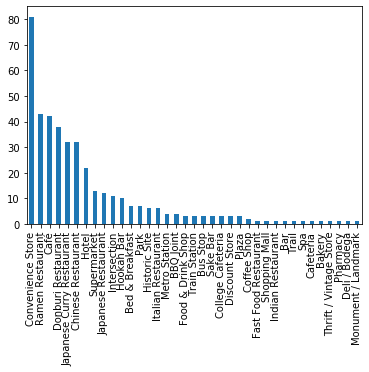

In [36]:
cluster1_top3 = cluster1[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']]
pd.concat([cluster1_top3[col] for col in cluster1_top3]).value_counts().plot.bar()
plt.show()

#### Cluster 2

In [28]:
cluster2 = kyoto_merged.loc[kyoto_merged['Cluster Labels'] == 1, kyoto_merged.columns[[1] + list(range(5, kyoto_merged.shape[1]))]]
cluster2

,PostalCode,Prefecture,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
227,6048273,KYOTO FU,KYOTO SHI NAKAGYO KU,ANENISHINOTOINCHO,35.009271,135.755482,1,Japanese Restaurant,Coffee Shop,Hotel,Bakery,Café,Ramen Restaurant,Convenience Store,Wagashi Place,Korean Restaurant,Shrine
230,6048216,KYOTO FU,KYOTO SHI NAKAGYO KU,IKESUCHO,35.006743,135.755519,1,Japanese Restaurant,Hotel,Coffee Shop,Ramen Restaurant,Convenience Store,Café,Sake Bar,Bakery,Chinese Restaurant,Wagashi Place
237,6048213,KYOTO FU,KYOTO SHI NAKAGYO KU,UBAYANAGICHO,35.006024,135.757394,1,Japanese Restaurant,Ramen Restaurant,Coffee Shop,Hotel,Sake Bar,Café,Bakery,Beer Bar,Furniture / Home Store,Convenience Store
238,6048256,KYOTO FU,KYOTO SHI NAKAGYO KU,ECHIGOCHO,35.007615,135.752939,1,Convenience Store,Japanese Restaurant,Bakery,Ramen Restaurant,Intersection,Café,Wagashi Place,Hotel,Coffee Shop,Chinese Restaurant
242,6048165,KYOTO FU,KYOTO SHI NAKAGYO KU,EBOSHIYACHO,35.007887,135.758435,1,Coffee Shop,Japanese Restaurant,Ramen Restaurant,Bakery,Café,Sake Bar,Hotel,Wagashi Place,Art Gallery,Bookstore
243,6048174,KYOTO FU,KYOTO SHI NAKAGYO KU,ENNOGYOJACHO,35.009203,135.758314,1,Japanese Restaurant,Café,Coffee Shop,Bakery,Hotel,Sake Bar,Wagashi Place,Ramen Restaurant,Museum,Art Gallery
244,6048175,KYOTO FU,KYOTO SHI NAKAGYO KU,EMPUKUJICHO,35.010401,135.758277,1,Japanese Restaurant,Café,Bakery,Coffee Shop,Hotel,Sake Bar,Ramen Restaurant,Soba Restaurant,Dessert Shop,Bookstore
250,6048173,KYOTO FU,KYOTO SHI NAKAGYO KU,KAKIMOTOCHO,35.009445,135.758974,1,Japanese Restaurant,Café,Coffee Shop,Bakery,Hotel,Wagashi Place,Sake Bar,Ramen Restaurant,Museum,Chocolate Shop
253,6048241,KYOTO FU,KYOTO SHI NAKAGYO KU,KAMANZACHO,35.008516,135.756058,1,Coffee Shop,Japanese Restaurant,Bakery,Hotel,Café,Ramen Restaurant,Sake Bar,Chinese Restaurant,Convenience Store,Wagashi Place
265,6048163,KYOTO FU,KYOTO SHI NAKAGYO KU,KOIYAMACHO,35.006763,135.758209,1,Coffee Shop,Japanese Restaurant,Ramen Restaurant,Café,Sake Bar,Bakery,Hotel,Furniture / Home Store,Museum,Italian Restaurant


##### plot common venues in this cluster

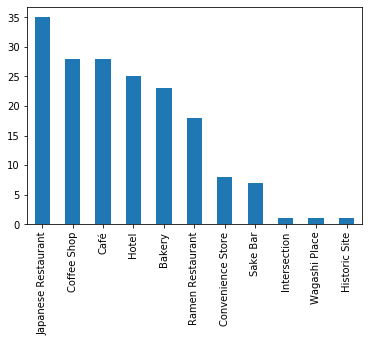

In [37]:
cluster2_top3 = cluster2[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']]
pd.concat([cluster2_top3[col] for col in cluster2_top3]).value_counts().plot.bar()
plt.show()

#### Cluster 3

In [30]:
cluster3 = kyoto_merged.loc[kyoto_merged['Cluster Labels'] == 2, kyoto_merged.columns[[1] + list(range(5, kyoto_merged.shape[1]))]]
cluster3

,PostalCode,Prefecture,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,6028472,KYOTO FU,KYOTO SHI KAMIGYO KU,ARIMACHO,35.030387,135.745635,2,Café,Convenience Store,Bakery,Chinese Restaurant,Ramen Restaurant,Intersection,Japanese Restaurant,Yoshoku Restaurant,Park,Soba Restaurant
5,6020064,KYOTO FU,KYOTO SHI KAMIGYO KU,ANRAKUKOJICHO,35.032808,135.755731,2,Café,Convenience Store,Intersection,Metro Station,Donburi Restaurant,Plaza,Ramen Restaurant,Japanese Curry Restaurant,Food & Drink Shop,Italian Restaurant
8,6028302,KYOTO FU,KYOTO SHI KAMIGYO KU,IDACHO,35.034755,135.742916,2,Café,Bus Stop,Intersection,Hostel,Park,Convenience Store,Bakery,Sake Bar,Liquor Store,Diner
9,6028471,KYOTO FU,KYOTO SHI KAMIGYO KU,ISSHIKICHO,35.031081,135.745440,2,Café,Convenience Store,Intersection,Bakery,Chinese Restaurant,Ramen Restaurant,Liquor Store,Soba Restaurant,Sake Bar,Pharmacy
12,6028497,KYOTO FU,KYOTO SHI KAMIGYO KU,INUICHO,35.035214,135.744312,2,Convenience Store,Café,Intersection,Hostel,Bakery,Soba Restaurant,Bus Stop,Yoshoku Restaurant,Liquor Store,Diner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,6020806,KYOTO FU,KYOTO SHI KAMIGYO KU,YABUNOSHITACHO,35.033546,135.764612,2,Convenience Store,Café,Liquor Store,Monument / Landmark,Clothing Store,Steakhouse,Art Museum,Dumpling Restaurant,French Restaurant,Forest
218,6028422,KYOTO FU,KYOTO SHI KAMIGYO KU,YAMANACHO,35.031525,135.751536,2,Convenience Store,Café,Japanese Restaurant,Bakery,Wagashi Place,Ramen Restaurant,Intersection,Japanese Curry Restaurant,Shrine,Performing Arts Venue
222,6020084,KYOTO FU,KYOTO SHI KAMIGYO KU,WAKAMIYAYOKOCHO,35.039036,135.748975,2,Convenience Store,Café,Bus Stop,Soba Restaurant,Bakery,Spa,Food & Drink Shop,Sake Bar,Bath House,Japanese Curry Restaurant
327,6048435,KYOTO FU,KYOTO SHI NAKAGYO KU,NISHINOKYO SANJOBOCHO,35.008920,135.731438,2,Convenience Store,Café,Intersection,Ramen Restaurant,Gastropub,Tea Room,Gym,Rock Club,Restaurant,Diner


##### plot common venues in this cluster

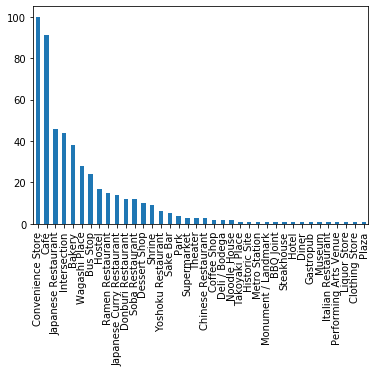

In [38]:
cluster3_top3 = cluster3[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']]
pd.concat([cluster3_top3[col] for col in cluster3_top3]).value_counts().plot.bar()
plt.show()

#### Cluster 4

In [32]:
cluster4 = kyoto_merged.loc[kyoto_merged['Cluster Labels'] == 3, kyoto_merged.columns[[1] + list(range(5, kyoto_merged.shape[1]))]]
cluster4

,PostalCode,Prefecture,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,6028278,KYOTO FU,KYOTO SHI KAMIGYO KU,AIZENJICHO,35.023407,135.743734,3,Convenience Store,Intersection,BBQ Joint,Japanese Restaurant,Café,Hostel,Chinese Restaurant,Bus Stop,Ramen Restaurant,Discount Store
6,6028297,KYOTO FU,KYOTO SHI KAMIGYO KU,ISEDONOKAMAECHO,35.026528,135.743878,3,Convenience Store,Café,Japanese Restaurant,Intersection,Chinese Restaurant,BBQ Joint,Ramen Restaurant,Bus Stop,Sake Bar,Monument / Landmark
14,6028292,KYOTO FU,KYOTO SHI KAMIGYO KU,IMASHINZAIKECHO,35.025669,135.746352,3,Convenience Store,Café,Japanese Restaurant,Chinese Restaurant,Intersection,BBQ Joint,Bakery,Ramen Restaurant,Donburi Restaurant,Sushi Restaurant
29,6028281,KYOTO FU,KYOTO SHI KAMIGYO KU,KAGAYACHO,35.024975,135.744959,3,Convenience Store,Café,Japanese Restaurant,Intersection,BBQ Joint,Chinese Restaurant,Bus Stop,Ramen Restaurant,Donburi Restaurant,Sake Bar
44,6028272,KYOTO FU,KYOTO SHI KAMIGYO KU,KAMEKICHO,35.023078,135.746352,3,Convenience Store,Café,Intersection,BBQ Joint,Japanese Restaurant,Chinese Restaurant,Bus Stop,Ramen Restaurant,Vegetarian / Vegan Restaurant,Takoyaki Place
46,6028296,KYOTO FU,KYOTO SHI KAMIGYO KU,KITAISEDONOKAMAECHO,35.026557,135.743093,3,Convenience Store,Japanese Restaurant,Café,Intersection,BBQ Joint,Chinese Restaurant,Ramen Restaurant,Sake Bar,Bus Stop,Supermarket
50,6028207,KYOTO FU,KYOTO SHI KAMIGYO KU,KITASHINZAIKECHO,35.026583,135.746378,3,Convenience Store,Café,Intersection,Japanese Restaurant,Chinese Restaurant,Ramen Restaurant,Bakery,Bus Stop,BBQ Joint,Sushi Restaurant
63,6028299,KYOTO FU,KYOTO SHI KAMIGYO KU,KODONOCHICHO,35.026368,135.745043,3,Convenience Store,Café,Intersection,Japanese Restaurant,Ramen Restaurant,BBQ Joint,Chinese Restaurant,Bus Stop,Bakery,Tea Room
64,6028275,KYOTO FU,KYOTO SHI KAMIGYO KU,KODOMAENOCHO,35.023100,135.742934,3,Convenience Store,Intersection,BBQ Joint,Japanese Restaurant,Chinese Restaurant,Café,Bus Stop,Ramen Restaurant,Donburi Restaurant,Drugstore
65,6020801,KYOTO FU,KYOTO SHI KAMIGYO KU,KOTOKUJICHO,35.036348,135.764505,3,Plaza,Art Museum,Spa,Monument / Landmark,Convenience Store,Trail,Music Venue,Deli / Bodega,Intersection,Fast Food Restaurant


##### plot common venues in this cluster

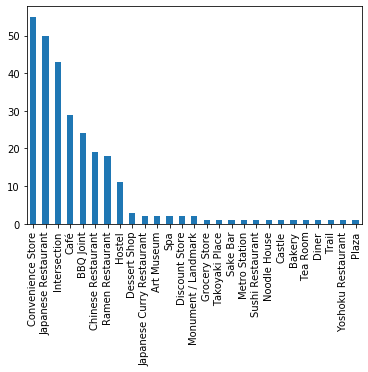

In [39]:
cluster4_top3 = cluster4[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']]
pd.concat([cluster4_top3[col] for col in cluster4_top3]).value_counts().plot.bar()
plt.show()

#### Cluster 5

In [34]:
cluster5 = kyoto_merged.loc[kyoto_merged['Cluster Labels'] == 4, kyoto_merged.columns[[1] + list(range(5, kyoto_merged.shape[1]))]]
cluster5

,PostalCode,Prefecture,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,6020827,KYOTO FU,KYOTO SHI KAMIGYO KU,AIOICHO,35.031141,135.769037,4,Café,Japanese Restaurant,Convenience Store,Coffee Shop,Bakery,Shopping Mall,Wagashi Place,Train Station,BBQ Joint,Chinese Restaurant
3,6020803,KYOTO FU,KYOTO SHI KAMIGYO KU,AMIDAJIMAECHO,35.033264,135.766436,4,Shopping Mall,Wagashi Place,Chinese Restaurant,Convenience Store,Bakery,Coffee Shop,Restaurant,Movie Theater,Sushi Restaurant,Clothing Store
7,6020873,KYOTO FU,KYOTO SHI KAMIGYO KU,ISEYACHO,35.017109,135.769349,4,Café,Japanese Restaurant,Convenience Store,Intersection,Bakery,Bar,French Restaurant,Ramen Restaurant,Brewery,Steakhouse
10,6020824,KYOTO FU,KYOTO SHI KAMIGYO KU,ISSHINCHO,35.029704,135.768777,4,Café,Japanese Restaurant,Bakery,Convenience Store,Coffee Shop,Shopping Mall,Wagashi Place,Train Station,BBQ Joint,Chinese Restaurant
11,6028238,KYOTO FU,KYOTO SHI KAMIGYO KU,ITOYACHO,35.028766,135.768710,4,Café,Japanese Restaurant,Coffee Shop,Bakery,Train Station,Shopping Mall,Convenience Store,Wagashi Place,Donut Shop,BBQ Joint
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,6040815,KYOTO FU,KYOTO SHI NAKAGYO KU,YAMANAKACHO,35.014897,135.761490,4,Japanese Restaurant,Café,Convenience Store,Historic Site,Bakery,Donburi Restaurant,Dessert Shop,Soba Restaurant,Yoshoku Restaurant,Beer Bar
379,6040933,KYOTO FU,KYOTO SHI NAKAGYO KU,YAMAMOTOCHO,35.012881,135.766715,4,Café,Japanese Restaurant,Bakery,Hotel,Chinese Restaurant,Convenience Store,Intersection,Bar,Inn,BBQ Joint
380,6040916,KYOTO FU,KYOTO SHI NAKAGYO KU,YOHOJIMAECHO,35.014309,135.767380,4,Café,Japanese Restaurant,Inn,Bakery,Hotel,French Restaurant,Bar,Paper / Office Supplies Store,Chinese Restaurant,Chocolate Shop
382,6040974,KYOTO FU,KYOTO SHI NAKAGYO KU,YONCHOME,35.016866,135.764322,4,Café,Historic Site,Park,Donburi Restaurant,Restaurant,French Restaurant,Bakery,Convenience Store,Dessert Shop,Science Museum


##### plot common venues in this cluster

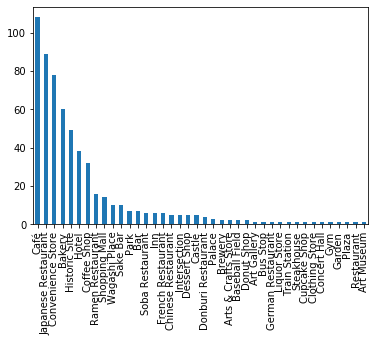

In [40]:
cluster5_top3 = cluster5[['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']]
pd.concat([cluster5_top3[col] for col in cluster5_top3]).value_counts().plot.bar()
plt.show()